## 日本語版注釈

Google Colaboratoryで動作させるように変更しています。

Jupyter Notebookで実行する場合は該当の部分のコメントアウトを変更してください。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DataScience/PyTorch/deep-learning-with-pytorch/p1ch2

Mounted at /content/drive
/content/drive/MyDrive/DataScience/PyTorch/deep-learning-with-pytorch/p1ch2


In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

CycleGAN
- 馬とシマウマの明示的に対応したペアは必要なく、それぞれを大量に用意すればよい
- 教師画像が不要という事
- 姿勢などは似ている方が訓練は早く終わりそう

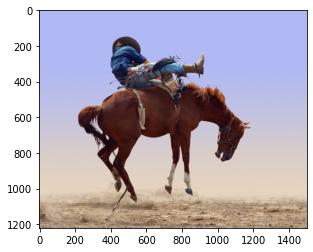

In [15]:
netG = ResNetGenerator()

# 学習済みモデルの重みをロード
model_path = '../data/p1ch2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

# 推論モード
netG.eval()

# 前処理用インスタンス
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

# 推論する画像
img = Image.open("../data/p1ch2/horse.jpg")
plt.imshow(img)

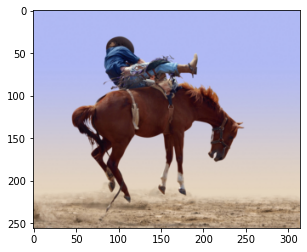

In [14]:
# 前処理
img_t = preprocess(img)
plt.imshow(img_t.permute(1,2,0))

In [10]:
# 推論実行
batch_t = torch.unsqueeze(img_t, 0)
batch_out = netG(batch_t)

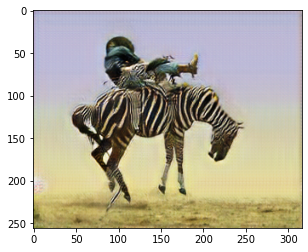

In [18]:
# 推論結果表示
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
plt.imshow(out_t.permute(1,2,0))